# Imports

In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
import myOptimizers as optims
import os
import importlib

# Function Definitions

In [2]:
# Weight initialisation
def init_random_params(scale, layer_sizes, rs=npr.RandomState(42)):
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

# Activation function
def tanh(x):
    return (2 / (1.0 + np.exp(-2*x))) - 1
    #return np.log(1+np.exp(x))
    #return np.exp(x)

# Returns the NN output AFTER enforcing the boundary condition. This is the wavefunction (wf).
def psi(nnparams, inputs):
    origInput = inputs
    xTilde = (origInput - x0) / (x1 - x0)
    
    for W, b in nnparams:
        outputs = np.dot(inputs, W) + b
        inputs = tanh(outputs)    
        
    # Enforcing the boundary conditions
    return (1-xTilde)*psi0 + xTilde*psi1 + (1-np.exp(xTilde * (1 - xTilde))) * outputs


dpsi = elementwise_grad(psi, 1) # Function for returning first derivative of wf (not used explicitly)
ddpsi = elementwise_grad(dpsi, 1) # Second derivative of wf. 

In [3]:
PRC1 = 20 # Probability regularisation co-efficient for degree 1 (and -1)
PRC2 = PRC1/(2*2) # Probability regularisation co-efficient for degree 2 (and -2)
PRC3 = PRC2/(2*3) # Probability regularisation co-efficient for degree 3 (and -3)
PRC4 = PRC3/(2*4) # Probability regularisation co-efficient for degree 4 (and -4)

def floatStr (Efloat) :
    Eint = int(np.floor(Efloat))
    if Efloat - Eint == 0 :
        return str(int(np.floor(Efloat)))
    else :
        Estr = str(Efloat)
        return str(int(np.floor(Efloat))) + "p" + Estr[Estr.find('.')+1:]

# Objective function
def objective(params, step):
    nnparams = params['nn']
    E = params['E']        
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    
    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    

    return np.mean(diffeq**2) + (1-prob)**2 + (PRC1/prob + PRC1*prob) + \
        (PRC2/prob**2 + PRC2*prob**2) + (PRC3/prob**3 + PRC3*prob**3) + \
        (PRC4/prob**4 + PRC4*prob**4)


trunc = -1
iterList = []
diffeqList = []
diffeqDiffList = []
probList = []
lossList = []
EList = []
# Helper function for callback. Prints the following -
# 1. Iteration no.
# 2. MSE term
# 3. Probability integral
# 4. Loss
# 5. Eigen-energy 
def objectiveDebug (params, step) :
    nnparams = params['nn']
    E = params['E']   
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    mean = np.mean(diffeq**2)  # MSE

    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    

    loss = mean + (1-prob)**2 + (PRC1/prob + PRC1*prob) + \
        (PRC2/prob**2 + PRC2*prob**2) + (PRC3/prob**3 + PRC3*prob**3) + \
        (PRC4/prob**4 + PRC4*prob**4)
    
    iterList.append (step)
    diffeqList.append (mean)
    probList.append (prob)
    lossList.append (loss)
    EList.append (float(params['E']))

    print ("Iteration " + str(step) + "\ndiffeq = " + str(mean) + " prob = " + str(prob))
    print ("loss = " + str(loss) + " E = " + str(params['E']))

# Callback function.
def callback(params, step, g):
    global trunc
    global diffeqList
    
    if step % 100 == 0:
        objectiveDebug (params, step)
        
        if step > 100 :
            if trunc == -1 and np.abs(diffeqDiffList[-1]) < 10**-2 and diffeqDiffList[-1] < 0 :
                trunc = int(step/100)
                print ("Set at index = " + str(trunc))        

# Initialisation

In [4]:
psi0 = 0.5 # Value of first boundary
psi1 = -0.5 # Value of second boundary
L = 1 # Length of the well
n = 1 # Energy level to be found
scale = 2*L # Scale for initialisation
divs = 200 # divisions of the input space

x0 = 0  # Position of first boundary
x1 = L  # Position of second boundary

In [5]:
# Initialising the weights. They usually fall between 0 and 1 which causes the initial wavefunction
# to have a small probability integral over the range. Hence, I've put a scale factor of 2 that changes gives it
# a random (but sizeable) shape so that over the epochs, the probability integral converges to 1.
nnparams = init_random_params(scale/(x1-x0), layer_sizes=[1, 32, 32, 1])

# Intialise a guess eigenvalue to find a true eigenvalue near it
initE = 4.0
params = {'nn': nnparams, 'E': initE}

# Input space
x = np.linspace(x0, x1, divs)[:, None]

# Setting up the name for saving files
name = "n" + str(n)+ "L" + floatStr(L) + "E" + floatStr(float(params['E']))

# Optimization

In [6]:
optims = importlib.reload (optims)
params = optims.myAdam (grad(objective), params, callback=callback, step_size=0.001, diffeqList=diffeqList, probList=probList, diffeqDiffList = diffeqDiffList)

Iteration 100
diffeq = 15.317907434553062 prob = 0.9417537473911193
loss = 67.3735776796312 E = 4.04972563093167
---------------------------------
Iteration 200
diffeq = 5.040985723021658 prob = 0.9689465586088308
loss = 56.965893721330715 E = 4.0725034090382595
diffeqDiff = -10.276921711531404
---------------------------------
Iteration 300
diffeq = 3.0158454965104613 prob = 0.980366269226616
loss = 54.91056535038117 E = 4.09706336186792
diffeqDiff = -2.0251402265111964
---------------------------------
Iteration 400
diffeq = 2.1375492077224316 prob = 0.9856736176914171
loss = 54.02299287270996 E = 4.1237267789789795
diffeqDiff = -0.8782962887880297
---------------------------------
Iteration 500
diffeq = 1.6387637583998247 prob = 0.9885521887872736
loss = 53.52041304903757 E = 4.1524297870401545
diffeqDiff = -0.49878544932260693
---------------------------------
Iteration 600
diffeq = 1.3212738524555327 prob = 0.9904348045448343
loss = 53.2009072962625 E = 4.182958255247637
diffeqDif

Iteration 4400
diffeq = 0.00752821001891536 prob = 0.9999280174927588
loss = 51.88252846997489 E = 4.9333374650857085
diffeqDiff = -0.00018889302731764368
brkCount3 = 11
---------------------------------
Iteration 4500
diffeq = 0.007951336060125522 prob = 1.0001893703275195
loss = 51.882953134759205 E = 4.933858698302137
diffeqDiff = 0.00042312604121016225
---------------------------------
Iteration 4600
diffeq = 0.007188327423147663 prob = 0.9998298507142334
loss = 51.8821897800295 E = 4.934228739288947
diffeqDiff = -0.0007630086369778593
brkCount3 = 12
---------------------------------
Iteration 4700
diffeq = 0.008280287232922161 prob = 1.0003528549923457
loss = 51.883286531157246 E = 4.934486714596379
diffeqDiff = 0.0010919598097744983
---------------------------------
Iteration 4800
diffeq = 0.006533881470337028 prob = 0.9999702123109351
loss = 51.88153392598485 E = 4.93466003696411
diffeqDiff = -0.0017464057625851334
brkCount2 = 11
---------------------------------
Iteration 4900


Iteration 8600
diffeq = 0.0026027918127900125 prob = 1.0005041337380929
loss = 51.87761553541698 E = 4.93487202231989
diffeqDiff = 0.0008066981328779589
---------------------------------
Iteration 8700
diffeq = 0.015262761817980674 prob = 0.997554445341689
loss = 51.890563516806736 E = 4.9348469521694955
diffeqDiff = 0.012659970005190662
---------------------------------
Iteration 8800
diffeq = 0.001650993250620827 prob = 0.9999657015849535
loss = 51.87665105226773 E = 4.934781784217445
diffeqDiff = -0.013611768567359846
---------------------------------
Iteration 8900
diffeq = 0.0021868326527812827 prob = 1.0002011138833031
loss = 51.87718886133378 E = 4.93486487665103
diffeqDiff = 0.0005358394021604557
---------------------------------
Iteration 9000
diffeq = 0.0015684584192693985 prob = 0.9999905209554303
loss = 51.8765684629269 E = 4.934780131832539
diffeqDiff = -0.0006183742335118842
brkCount3 = 28
---------------------------------
Iteration 9100
diffeq = 0.0025068796019728445 pro

Iteration 11900
diffeq = 0.0008510634998398236 prob = 1.0000698344519856
loss = 51.875851308138444 E = 4.934807721710376
diffeqDiff = -0.05059199234277426
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 11600
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 12000
diffeq = 0.2677816830605184 prob = 0.9865455330142989
loss = 52.15198477612057 E = 4.934967797012852
diffeqDiff = 0.2669306195606786
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 11600
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 12100
diffeq = 0.0008223635717187249 prob = 0.999996228260994
loss = 51.87582236428539 E = 4.934796546930695
diffeqDiff = -0.2669593194887997
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 11600
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 12200
diffeq = 0.0008045185375320055 prob = 0.9999968966595437
loss = 51.875804519020676 E = 4.934806888012423
dif

Iteration 14700
diffeq = 0.020480273667816854 prob = 1.0023513142097529
loss = 51.89575699175685 E = 4.934963374914348
diffeqDiff = 0.019909312827728374
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 11600
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 14800
diffeq = 0.041903604936359605 prob = 0.9962473283466684
loss = 51.91761268977479 E = 4.935069909217917
diffeqDiff = 0.02142333126854275
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 11600
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 14900
diffeq = 0.0006886683778954021 prob = 1.0002597856496935
loss = 51.87569205319345 E = 4.934807733123007
diffeqDiff = -0.041214936558464206
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 11600
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 15000
diffeq = 0.0005549401902749608 prob = 0.9998914585949259
loss = 51.87555553127852 E = 4.934789942920748


Iteration 17500
diffeq = 0.0014331347654980631 prob = 0.9991285129177627
loss = 51.87647126841192 E = 4.9348079692956786
diffeqDiff = 0.0010156375271316892
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 11600
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 17600
diffeq = 0.0004058289612310012 prob = 0.9999851377897568
loss = 51.87540584004247 E = 4.934812097857347
diffeqDiff = -0.0010273058042670619
brkCount2 = 28
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 11600
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 17700
diffeq = 0.0005955261383606594 prob = 0.9999967550301508
loss = 51.875595526666615 E = 4.934815550658968
diffeqDiff = 0.00018969717712965817
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 11600
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 17800
diffeq = 0.005025619474655468 prob = 0.9989253070637583
loss = 51.88008362132325

Iteration 20300
diffeq = 0.0022284914220584476 prob = 0.9996550886873807
loss = 51.87723446145831 E = 4.934871705988744
diffeqDiff = 0.0011691679549501387
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 11600
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 20400
diffeq = 0.0003116884806789995 prob = 0.9999832906366681
loss = 51.87531170248758 E = 4.934813441834637
diffeqDiff = -0.0019168029413794481
brkCount2 = 37
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 11600
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 20500
diffeq = 0.0007912311845295983 prob = 0.9999155392212378
loss = 51.875791589084244 E = 4.934806445547023
diffeqDiff = 0.0004795427038505988
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 11600
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 20600
diffeq = 0.0003671684721857598 prob = 0.9999377722738104
loss = 51.87536736274391 

Iteration 23100
diffeq = 0.0005794855180476355 prob = 1.0005407505880366
loss = 51.8755941470441 E = 4.934828256871332
diffeqDiff = -0.01014035029737944
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 11600
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 23200
diffeq = 0.024672154769306606 prob = 1.0019014814799592
loss = 51.899853201740804 E = 4.934765913600201
diffeqDiff = 0.02409266925125897
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 11600
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 23300
diffeq = 0.00024844610354043684 prob = 0.9999728340684534
loss = 51.875248483126924 E = 4.934817270096626
diffeqDiff = -0.02442370866576617
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 11600
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 23400
diffeq = 0.000451626832982587 prob = 0.9996080240177119
loss = 51.87545933766157 E = 4.934842920606794

Iteration 25900
diffeq = 0.0011619893375558338 prob = 1.000232547332327
loss = 51.87616470164557 E = 4.934807215267186
diffeqDiff = 0.0009404890514342939
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 11600
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 26000
diffeq = 0.0002468701665834593 prob = 0.9997451649835594
loss = 51.87525012884827 E = 4.934814893227464
diffeqDiff = -0.0009151191709723744
brkCount3 = 44
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 11600
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 26100
diffeq = 0.00023901250044482575 prob = 1.0000528651534986
loss = 51.875239152695194 E = 4.934830702190386
diffeqDiff = -7.857666138633569e-06
brkCount4 = 9
Beyond 10,000th iteration
Hit 10**-4 already
endLim = 11600
Will eventually hit 10 of 10**-4 (or has hit)
---------------------------------
Iteration 26200
diffeq = 0.0002332749014377654 prob = 0.999830685078102
loss = 51.8

# Plots

In [14]:
replot = 1
if replot == 1 :
    params['E'] = initE
    n = 1
    L = 1
    name = "n" + str(n)+ "L" + floatStr(L) + "E" + floatStr(float(params['E']))

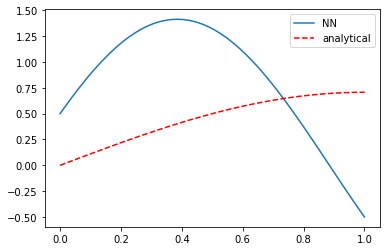

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
x = np.linspace(x0, x1)[:, None]
y = psi(params['nn'], x)

plt.plot(x, y, label='NN')  # Plotting the NN output
plt.plot(x, np.sqrt(2/L) * np.sin(n*np.pi * (x-x0)/L), 'r--', label='analytical')  # Plotting the actual wavefuncion
plt.legend()
plt.savefig (name + "_plot.png")

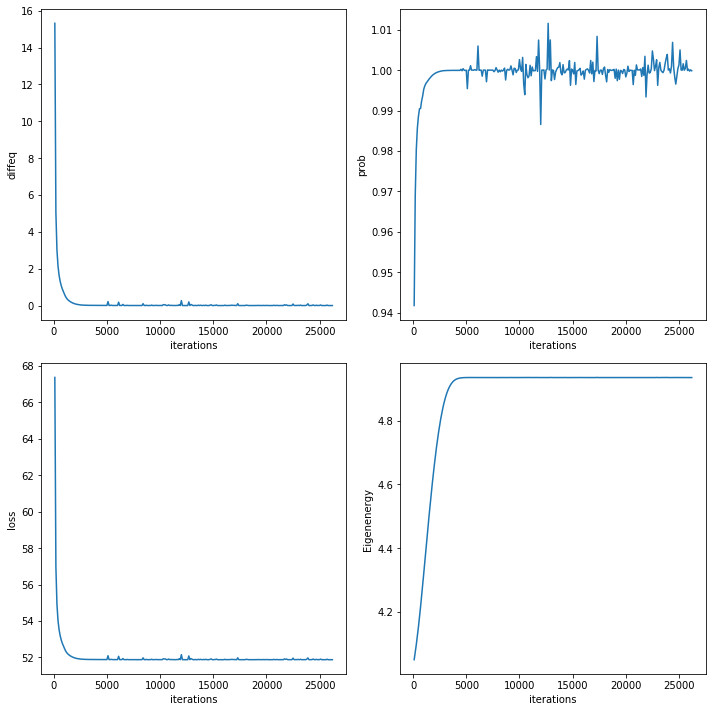

In [9]:
fig = plt.figure (figsize=(10,10))
plt.clf ()

plt.subplot (2 , 2 , 1)
plt.plot (iterList, diffeqList)
plt.xlabel ('iterations')
plt.ylabel ('diffeq')

plt.subplot (2, 2, 2)
plt.plot (iterList, probList)
plt.xlabel ('iterations')
plt.ylabel ('prob')

plt.subplot (2, 2, 3)
plt.plot (iterList, lossList)
plt.xlabel ('iterations')
plt.ylabel ('loss')

plt.subplot (2, 2, 4)
plt.plot (iterList, EList)
plt.ylabel ('Eigenenergy')
plt.xlabel ('iterations')
plt.tight_layout()

plt.savefig (name + "_diagAll.png")

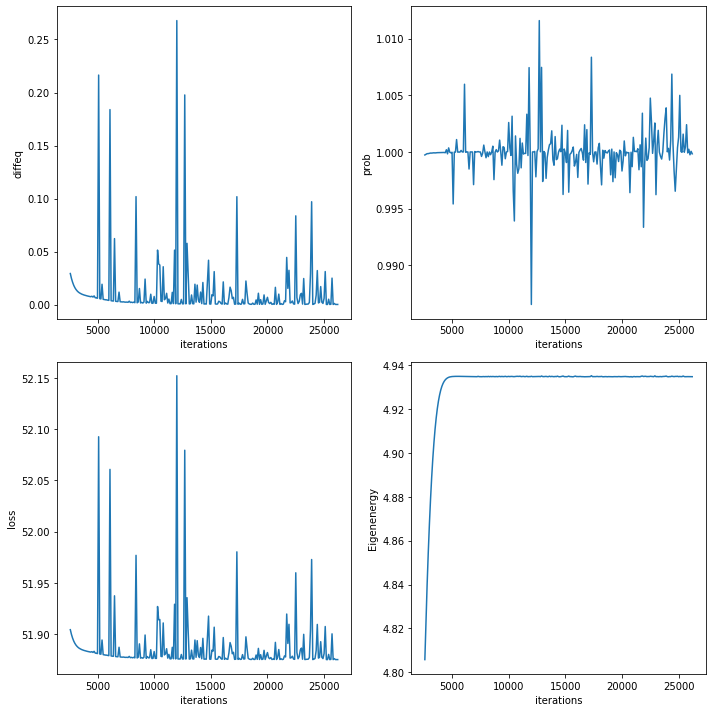

In [10]:
if trunc != -1 :
    fig = plt.figure (figsize=(10,10))

    plt.subplot (2 , 2 , 1)
    plt.plot (iterList[trunc:], diffeqList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('diffeq')

    plt.subplot (2, 2, 2)
    plt.plot (iterList[trunc:], probList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('prob')

    plt.subplot (2, 2, 3)
    plt.plot (iterList[trunc:], lossList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('loss')

    plt.subplot (2, 2, 4)
    plt.plot (iterList[trunc:], EList[trunc:])
    plt.ylabel ('Eigenenergy')
    plt.xlabel ('iterations')
    plt.tight_layout()

    plt.savefig (name + "_diagTrunc" + str(trunc) + ".png")

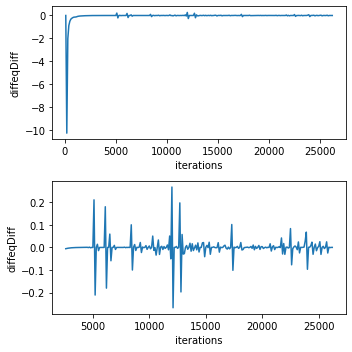

In [11]:
fig = plt.figure (figsize=(5,5))
plt.clf ()

if trunc != -1 :
    plt.subplot (2 , 1 , 1)
    plt.plot (iterList, diffeqDiffList)
    plt.xlabel ('iterations')
    plt.ylabel ('diffeqDiff')

    plt.subplot (2 , 1 , 2)
    plt.plot (iterList[trunc:], diffeqDiffList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('diffeqDiff')
else :
    plt.plot (iterList, diffeqDiffList)
    #plt.yticks ([min(diffeqDiffList), -10**-4, 10**-4, max(diffeqDiffList)])
    plt.xlabel ('iterations')
    plt.ylabel ('diffeqDiff')

plt.tight_layout()
plt.savefig (name + "_diffeqDiff.png")

# Write to file

In [12]:
outfile = open(name + "_info.txt" , "w")

fstr = "diffeq = " + str(round(diffeqList[-1],8)) + \
"\nprob = " + str(round(probList[-1],8)) + \
"\nloss = " + str(round(lossList[-1],8)) + \
"\neigE = " + str(round(EList[-1],8)) + \
"\ndiffeqDiff = " + str(round(diffeqDiffList[-1],8))

    
outfile.write (fstr)
outfile.close ()